In [1]:
import pandas as pd
import chardet
import re

def read_csv_auto_encoding(file_path, delimiter):
    # Phát hiện mã hóa tự động
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))
    
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")
    
    # Đọc tệp CSV với mã hóa được phát hiện
    try:
        df = pd.read_csv(file_path, delimiter=delimiter, encoding=encoding)            
        return df
    except Exception as e:
        print(f"Error with detected encoding {encoding}:", e)
        # Thử mã hóa phổ biến khác
        for enc in ['latin1', 'iso-8859-1', 'cp1252']:
            try:
                df = pd.read_csv(file_path, delimiter=delimiter, encoding=enc)
                print(f"Successfully read the file with encoding: {enc}")
                return df
            except Exception as e:
                print(f"Error with encoding {enc}:", e)
                
        return None
    


# Hàm loại bỏ stop words
def remove_stop_words(text):
    words = re.findall(r'\w+', text)  # Tách từ
    words_filtered = [word for word in words if word.lower() not in stop_words]  # Loại bỏ stop words
    return ' '.join(words_filtered)

In [2]:
df1 = read_csv_auto_encoding('data/Goodreads-books/books_corrected.csv', ",")

# Đổi tên cột để thống nhất
df1.rename(columns={
    'bookID': 'BookID',
    'title': 'Title',
    'authors': 'Authors',
    'average_rating': 'AvgReviews',
    'isbn': 'ISBN',
    'isbn13': 'ISBN13',
    'language_code': 'LanguageCode',
    'num_pages': 'NumPages',
    'ratings_count': 'NReviews',
    'text_reviews_count': 'TextReviewsCount',
    'publication_date': 'PublicationDate',
    'publisher': 'Publisher'
}, inplace=True)

# Đọc danh sách stop words từ tệp
stop_words = set()
with open('stopwords.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        # Bỏ qua các dòng bắt đầu bằng dấu '#'
        if word and not word.startswith('#'):
            stop_words.add(word)

# Áp dụng hàm loại bỏ stop words lên cột 'Title'
df1['TitleClear'] = df1['Title'].apply(lambda x: remove_stop_words(x) if isinstance(x, str) else x)

# Kiểm tra kết quả
print(df1[['TitleClear']].head())

# Chuẩn hóa dữ liệu trong các cột 'TitleClear', 'Authors' và 'Publisher'
df1['TitleClear'] = df1['TitleClear'].str.lower().str.replace(' ', '_')
df1['AuthorsClear'] = df1['Authors'].str.lower().str.replace(' ', '_')
df1['PublisherClear'] = df1['Publisher'].str.lower().str.replace(' ', '_')
df1['ISBN'] = df1['ISBN'].str.lower()

# Chuyển đổi cột PublicationDate sang định dạng datetime nếu chưa làm
df1['PublicationDate'] = pd.to_datetime(df1['PublicationDate'], errors='coerce')

# Tách cột PublicationDate thành ba cột: PublicationDay, PublicationMonth, PublicationYear
df1['PublicationDay'] = df1['PublicationDate'].dt.day
df1['PublicationMonth'] = df1['PublicationDate'].dt.month
df1['PublicationYear'] = df1['PublicationDate'].dt.year

# Điền giá trị NULL cho dữ liệu bị khuyết
df1 = df1.where(pd.notnull(df1), None)

# Kiểm tra lại DataFrame sau khi thực hiện các bước trên
print(df1.head())



Detected encoding: utf-8
                                          TitleClear
0      Harry Potter Half Blood Prince Harry Potter 6
1                Harry Potter Phoenix Harry Potter 5
2        Harry Potter Chamber Secrets Harry Potter 2
3       Harry Potter Prisoner Azkaban Harry Potter 3
4  Harry Potter Boxed Set Books 1 5 Harry Potter 1 5
   BookID                                              Title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   
1       2  Harry Potter and the Order of the Phoenix (Har...   
2       4  Harry Potter and the Chamber of Secrets (Harry...   
3       5  Harry Potter and the Prisoner of Azkaban (Harr...   
4       8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      Authors  AvgReviews        ISBN         ISBN13  \
0  J.K. Rowling/Mary GrandPré        4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré        4.49  0439358078  9780439358071   
2                J.K. Rowling        4.42  0439554896  9

LanguageCode
eng      8908
en-US    1408
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64


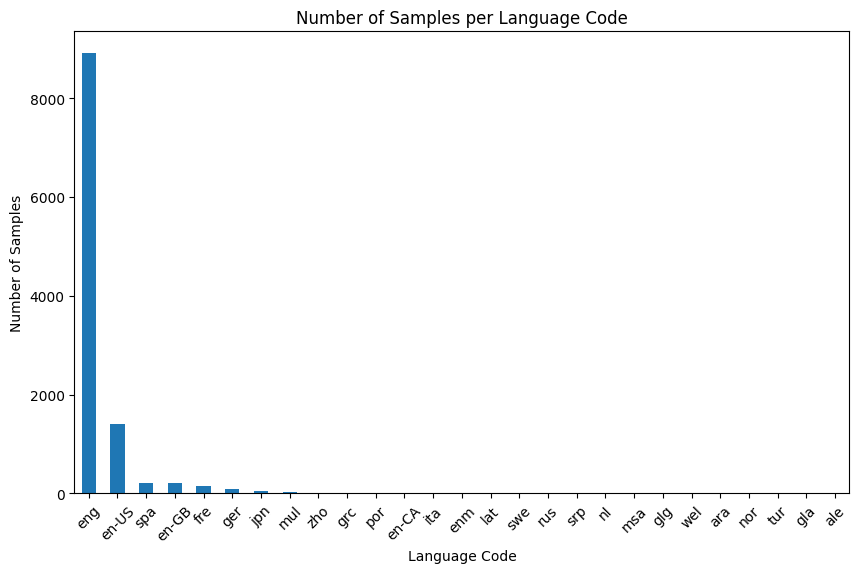

In [3]:
import matplotlib.pyplot as plt
# Thống kê số lượng giá trị khác nhau và số lượng mẫu của mỗi giá trị
language_counts = df1['LanguageCode'].value_counts()
print(language_counts)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar')
plt.xlabel('Language Code')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Language Code')
plt.xticks(rotation=45)
plt.show()

In [4]:
# Bảng ánh xạ viết tắt sang giá trị đầy đủ
language_mapping = {
    'eng': 'english',
    'en-US': 'english (US)',
    'spa': 'spanish',
    'en-GB': 'english (GB)',
    'fre': 'french',
    'ger': 'german',
    'jpn': 'japanese',
    'mul': 'multiple languages',
    'zho': 'chinese',
    'grc': 'greek',
    'por': 'portuguese',
    'en-CA': 'english (CA)',
    'ita': 'italian',
    'enm': 'middle english',
    'lat': 'latin',
    'swe': 'swedish',
    'rus': 'russian',
    'srp': 'serbian',
    'nl': 'dutch',
    'msa': 'malay',
    'glg': 'galician',
    'wel': 'welsh',
    'ara': 'arabic',
    'nor': 'norwegian',
    'tur': 'turkish',
    'gla': 'scottish gaelic',
    'ale': 'aleut',
    'kor': 'korean',
    'hin': 'hindi',
    'ben': 'bengali',
    'urd': 'urdu',
    'vie': 'vietnamese',
    'tam': 'tamil',
    'tha': 'thai',
    'pol': 'polish',
    'ukr': 'ukrainian',
    'ces': 'czech',
    'slo': 'slovak',
    'dan': 'danish',
    'fin': 'finnish',
    'hun': 'hungarian',
    'heb': 'hebrew',
    'ind': 'indonesian',
    'mal': 'malayalam',
    'kan': 'kannada',
    'tel': 'telugu',
    'mar': 'marathi',
    'guj': 'gujarati',
    'bur': 'burmese',
    'khm': 'khmer',
    'lao': 'lao',
    'sin': 'sinhala',
    'mya': 'burmese',
    'slv': 'slovenian',
    'hrv': 'croatian',
    'bos': 'bosnian',
    'srp': 'serbian',
    'bul': 'bulgarian',
    'ron': 'romanian',
    'lit': 'lithuanian',
    'lav': 'latvian',
    'est': 'estonian',
    'isl': 'icelandic'
}


In [5]:
import os

# Define the directory and file path
directory = 'data/data_clearn/Goodreads-books'
file_path = os.path.join(directory, 'books_1.csv')

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Thay thế viết tắt bằng giá trị đầy đủ nếu có trong bảng ánh xạ, nếu không thì giữ nguyên
df1['LanguageCode'] = df1['LanguageCode'].apply(lambda x: language_mapping.get(x, x))

# Save the processed data to the new file
df1.to_csv(file_path, index=False)

In [6]:
import isbnlib

# Hàm chuyển đổi ISBN-10 sang ISBN-13
def convert_isbn10_to_isbn13(isbn10):
    try:
        isbn13 = isbnlib.to_isbn13(isbn10)
        return isbn13
    except isbnlib.NotValidISBNError:
        return None

# Hàm để chuyển đổi ISBN-10 hoặc giữ nguyên ISBN-13
def get_isbn13(isbn):
    isbn = str(isbn)
    if len(isbn) == 10:
        return convert_isbn10_to_isbn13(isbn)
    elif len(isbn) == 13:
        return isbn
    else:
        return None
    
# Hàm chuyển đổi từ hệ 10 sang hệ 5
def convert_to_scale_5(rating):
    if rating == 0:
        return 0  # Điểm 0 vẫn giữ nguyên
    elif rating <= 2:
        return 1  # Điểm 1
    elif rating <= 4:
        return 2  # Điểm 2
    elif rating <= 6:
        return 3  # Điểm 3
    elif rating <= 8:
        return 4  # Điểm 4
    else:
        return 5  # Điểm 5    
    
# Hàm chuyển đổi ISBN-13 sang ISBN-10
def convert_isbn13_to_isbn10(isbn13):
    try:
        isbn10 = isbnlib.to_isbn10(isbn13)
        return isbn10
    except isbnlib.NotValidISBNError:
        return None    

In [7]:
df2_books = read_csv_auto_encoding("data/Book Recommendation Dataset/Book reviews/BX_Books.csv" , ";")

# Đổi tên cột để thống nhất
df2_books.rename(columns={
    'ISBN': 'ISBN',
    'Book-Title': 'Title',
    'Book-Author': 'Authors',
    'Year-Of-Publication': 'PublicationYear',
    'Publisher': 'Publisher'
}, inplace=True)


# Đọc danh sách stop words từ tệp
stop_words = set()
with open('stopwords.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        # Bỏ qua các dòng bắt đầu bằng dấu '#'
        if word and not word.startswith('#'):
            stop_words.add(word)

# Áp dụng hàm loại bỏ stop words lên cột 'Title'
df2_books['TitleClear'] = df2_books['Title'].apply(lambda x: remove_stop_words(x) if isinstance(x, str) else x)

# Chuẩn hóa dữ liệu trong các cột 'Title'  'Authors' và Publisher
df2_books['TitleClear'] = df2_books['TitleClear'].str.lower().str.replace(' ', '_')
df2_books['AuthorsClear'] = df2_books['Authors'].str.lower().str.replace(' ', '_')
df2_books['PublisherClear'] = df2_books['Publisher'].str.lower().str.replace(' ', '_')
df2_books['ISBN'] = df2_books['ISBN'].str.lower()

# Thêm cột ISBN13 vào DataFrame
df2_books['ISBN13'] = df2_books['ISBN'].apply(get_isbn13)

# Điền giá trị NULL cho dữ liệu bị khuyết
df2_books = df2_books.where(pd.notnull(df2_books), None)

df2_books.to_csv("data/data_clearn/Book Recommendation Dataset/books_2.csv", index=False)



Detected encoding: ISO-8859-1


In [ ]:
df2_ratings = read_csv_auto_encoding("data/Book Recommendation Dataset/Book reviews/BX-Book-Ratings.csv" , ";")

df2_ratings.rename(columns={
    'User-ID': 'UserID',
    'ISBN': 'ISBN',
    'Book-Rating': 'Rating_10'
}, inplace=True)

# Thêm cột ISBN13 vào DataFrame
df2_ratings['ISBN13'] = df2_ratings['ISBN'].apply(lambda x: convert_isbn10_to_isbn13(x) if pd.notnull(x) else None)

# Thêm cột Rating_5
df2_ratings['Rating_5'] = df2_ratings['Rating_10'].apply(lambda x: x if pd.notnull(x) else None)

df2_ratings = df2_ratings.where(pd.notnull(df2_ratings), None)
df2_ratings.to_csv("data/data_clearn/Book Recommendation Dataset/books_ratings_2.csv", index=False)

In [ ]:
df2_users = read_csv_auto_encoding("data/Book Recommendation Dataset/Book reviews/BX-Users.csv" , ";")

df2_users.rename(columns={
    'User-ID': 'UserID',
    'Location': 'Location',
    'Age': 'Age'
}, inplace=True)

df2_users = df2_users.where(pd.notnull(df2_users), None)
df2_users.to_csv("data/data_clearn/Book Recommendation Dataset/users.csv", index=False)

In [18]:
df3 = read_csv_auto_encoding("data/BooksDataset/BooksDatasetClean.csv" , ",")

# Đổi tên cột để thống nhất
df3.rename(columns={
    'Title': 'Title',
    'Author': 'Authors',
    'Description' : 'Description',
    'Category' : 'Category' ,
    'Publisher': 'Publisher',
    'Price Starting With ($)': 'Price',
    'Publish Date (Month)' : 'PublicationMonth' ,
    'Publish Date (Year)' : 'PublicationYear'
    
}, inplace=True)


# Đọc danh sách stop words từ tệp
stop_words = set()
with open('stopwords.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        # Bỏ qua các dòng bắt đầu bằng dấu '#'
        if word and not word.startswith('#'):
            stop_words.add(word)

# Áp dụng hàm loại bỏ stop words lên cột 'Title'
df3['TitleClear'] = df3['Title'].apply(lambda x: remove_stop_words(x) if isinstance(x, str) else x)

df3['AuthorsClear'] = df3['Authors'].apply(lambda x: remove_stop_words(x) if isinstance(x, str) else x)
# Kiểm tra kết quả
print(df3[['TitleClear']].head())

# Chuẩn hóa dữ liệu trong các cột 'TitleClear', 'Authors' và 'Publisher'
df3['TitleClear'] = df3['TitleClear'].str.lower().str.replace(' ', '_')
df3['AuthorsClear'] = df3['AuthorsClear'].str.lower().str.replace(' ', '_')
df3['PublisherClear'] = df3['Publisher'].str.lower().str.replace(' ', '_')

# Điền giá trị NULL cho dữ liệu bị khuyết
df3 = df3.where(pd.notna(df3), None)

df3.to_csv("data/data_clearn/books_3.csv", index=False)


Detected encoding: ascii
Error with detected encoding ascii: 'ascii' codec can't decode byte 0xe2 in position 43809: ordinal not in range(128)
Successfully read the file with encoding: latin1
                                          TitleClear
0                                      Goat Brothers
1                                     Missing Person
2                             Don Eat Heart Cookbook
3  Corporate Umbrella Begins Leak Handbook White ...
4            Amy Spangler Breastfeeding Parent Guide
